# Finetune a pretrained imageNet CNN for cifar10 classification

**Goal:**  The goal is to use a pretrained CNN 

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.  

**Dataset:** In this notebook you work with the Cifar10 dataset. You have 60'000 32x32 pixel color images of 10 classes ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck").  


Original python version CHECK AND ADAPT
| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_02/nb_ch02_03.ipynb)


# Installing TensorFlow and Keras

The deep learning packages, TensorFlow and Keras are not installed by default, but can be installed as follows:

In [2]:
#Installing TF and Keras takes approx 2 minutes
ptm <- proc.time()
install.packages("tensorflow")
install.packages("keras")
install.packages("RCurl")
install.packages("kableExtra")
install.packages("reshape2")
proc.time() - ptm
#devtools::install_github("rstudio/keras") works ok but no tfp


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rappdirs’, ‘config’, ‘reticulate’, ‘tfruns’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘bitops’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘webshot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’




   user  system elapsed 
 62.421   8.554  77.396 

[1] "2.3.0"

# Imports

In the next cell, we load all the required libraries and functions. 

In [5]:
library(keras)
library(tensorflow)
tf$version$VERSION #2.3.0
library(tidyverse)
require(graphics)


[1] "2.3.0"

# Data
Let's get the cifar10 data. Normalize the image data and reformat the labels to one-hot-encoded. m

In [19]:
cifar10 <- dataset_cifar10()
c(x_train, y_train) %<-% cifar10$train
c(x_test, y_test) %<-% cifar10$test

to_one_hot <- function(labels, dimension = 10) {
  results <- matrix(0, nrow = length(labels), ncol = dimension)
  for (i in 1:length(labels))
    results[i, labels[[i]] + 1] <- 1
  results
}
X_train <- x_train[1:10000,,,]/255
X_val <- x_train[10001:20000,,,]/255
X_test <- x_test/255

Y_train <- to_one_hot(y_train[1:10000])
Y_val <- to_one_hot(y_train[10001:20000])
Y_test <- to_one_hot(y_test)



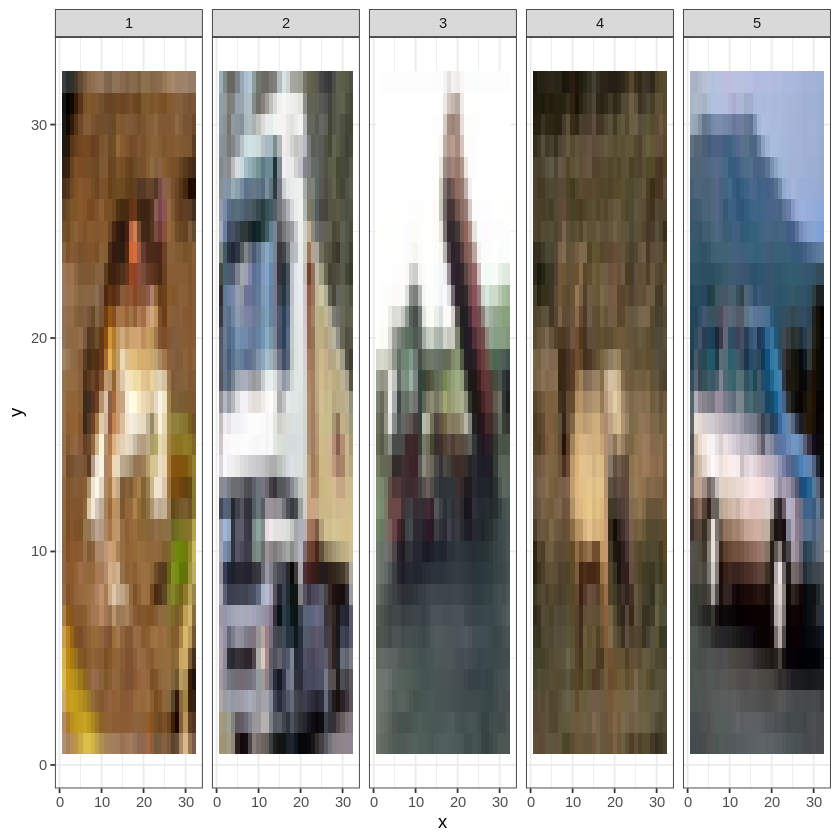

In [12]:
#have a look on the images:
dd <- expand.grid(1:32,1:32)
colnames(dd) <- c("x","y")
dd <- data.frame(x=rep(dd$x,5),y=rep(dd$y,5))
dd$r <- NA
dd$g <- NA
dd$b <- NA
dd$pic <- rep(1:5,each=32*32)
idx <- 32:1
idx2 <- c("r","g","b")

for (k in 1:5){
  for (j in 1:3){
    for (i in 1:32){
      dd[dd$y==idx[i] & dd$pic==k,idx2[j]] <- x_train[k,i,,j]
    }
  }
}
dd$r <- dd$r/255
dd$g <- dd$g/255
dd$b <- dd$b/255
ggplot(data=dd, aes(x=x, y=y, fill=rgb(r,g,b))) +
  geom_tile() +
  scale_fill_identity() +
  theme_bw()+
  facet_wrap(~pic,ncol=5)

# Working with a pretrained VGG model

Let's instantiate the VGG16 model that was trained on the huge imageNet data (1000000 instances) with 1000 classes:

In [6]:
## edit from original keras function:
application_vgg16 = function (include_top = TRUE,
                              weights = "imagenet",
                              input_tensor = NULL,
                              input_shape = NULL,
                              pooling = NULL,
                              classes = 1000){
  # MP: comment out next line
  #verify_application_prerequistes()
  # MP: prefix "tf$" to next line.
  tf$keras$applications$VGG16(include_top = include_top, weights = weights, 
    input_tensor = input_tensor, 
    # MP: comment out next line, include succeeding line
    #input_shape = normalize_shape(input_shape)
    input_shape = input_shape, 
    pooling = pooling, classes = as.integer(classes))
}

In [7]:
base_model <- application_vgg16(weights = "imagenet",
                           include_top = FALSE,
                           input_shape = c(32L, 32L, 3L))
summary(base_model)

Model: "vgg16"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                [(None, 32, 32, 3)]             0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, 32, 32, 64)              1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, 32, 32, 64)              36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, 16, 16, 64)              0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, 16, 16, 128)             73856       
________________________________________________________________________________
block2_conv2 

In [14]:

# i.e. freeze all convolutional VGG16 layers
freeze_weights(base_model)

In [22]:
# prepare new head for our 10 cifar10 classes 
predictions <- base_model$output %>% 
layer_flatten() %>% 
layer_dense(units = 100, activation = "relu") %>% 
layer_dropout(rate = 0.2) %>%
layer_dense(units = 10, activation = "softmax")


In [23]:
summary(predictions)

Tensor("dense_6/Softmax:0", shape=(None, 10), dtype=float32)


In [24]:
# this is the model we will train
model <- keras_model(inputs = base_model$input, outputs = predictions)
# summary(model)

Model: "functional_5"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
input_1 (InputLayer)                [(None, 32, 32, 3)]             0           
________________________________________________________________________________
block1_conv1 (Conv2D)               (None, 32, 32, 64)              1792        
________________________________________________________________________________
block1_conv2 (Conv2D)               (None, 32, 32, 64)              36928       
________________________________________________________________________________
block1_pool (MaxPooling2D)          (None, 16, 16, 64)              0           
________________________________________________________________________________
block2_conv1 (Conv2D)               (None, 16, 16, 128)             73856       
________________________________________________________________________________
block2

In [18]:
# compile model
model %>% compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

Finetune the VGG model (with frozen convolutional part) to the cifar10 data:

In [11]:
history <- model %>% fit(
  X_train, Y_train, 
  epochs = 20,
  batch_size=128,
  verbose=1,
  validation_data = list(X_val, Y_val))

`geom_smooth()` using formula 'y ~ x'



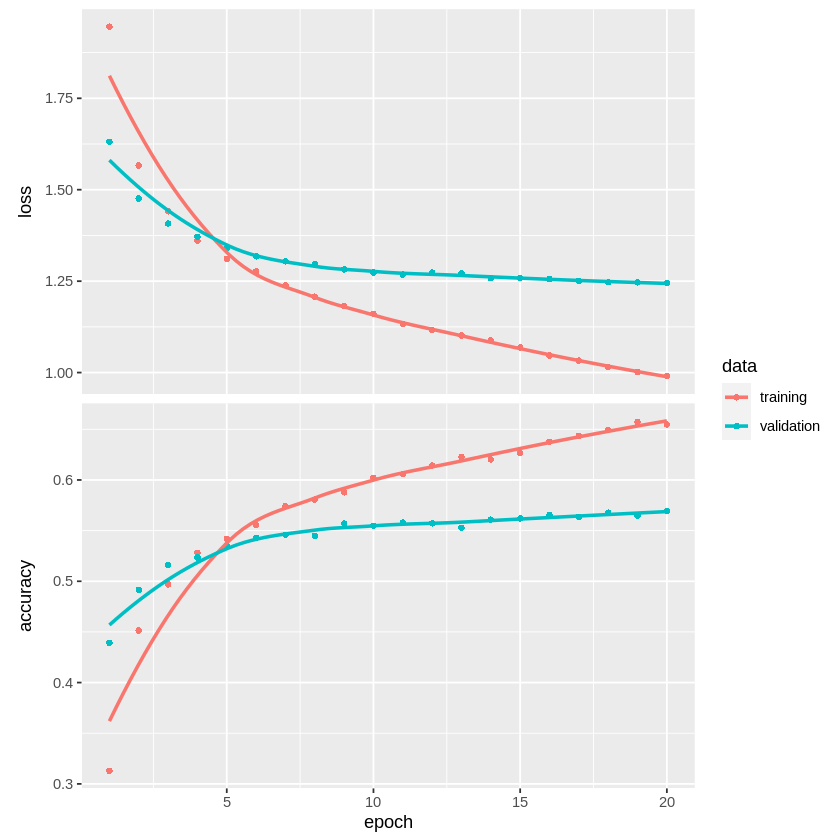

In [13]:
plot(history)

Prepare the labels as one-hot-encoded.


In [ ]:
to_one_hot <- function(labels, dimension = 10) {
  results <- matrix(0, nrow = length(labels), ncol = dimension)
  for (i in 1:length(labels))
    results[i, labels[[i]] + 1] <- 1
  results
}
X_train <- x_train[1:10000,,,]/255
X_val <- x_train[10001:20000,,,]/255
X_test <- x_test/255

Y_train <- to_one_hot(y_train[1:10000])
Y_val <- to_one_hot(y_train[10001:20000])
Y_test <- to_one_hot(y_test)

Here we make the labels for the art lover, 0 means he likes the image and 1 means that he doesn't like it. We convert the labels into the one hot encoding becuase we want to use two outputs in our network.

In [ ]:
Y_train <- cbind(c(rep(1,num_images_train/2),
                   rep(0,num_images_train/2)),
                 c(rep(0,num_images_train/2),
                   rep(1,num_images_train/2)))
Y_val <- cbind(c(rep(1,num_images_train/2),
                 rep(0,num_images_train/2)),
                 c(rep(0,num_images_train/2),
                   rep(1,num_images_train/2)))

# Defining the CNN to predict the CPD

### Hyper Parameters:

* use the relu activation function*  
* use kernelsize of 3x3*  
* use poolingsize of 2x2*  
* use 2 convolutional blocks with 8 filters and then a maxpooling layer followed by again 2 convolutional blocks with 16 filters and then a maxpooling*  
* flatten the output of the convolutional part and use in the fully connected part a hidden layer with 40 nodes and a output layer with 10 nodes with softmax activation.*  


In [ ]:
batch_size = 128
nb_classes = 10
img_rows = 32
img_cols = 32
kernel_size = c(3, 3)
input_shape = c(img_rows, img_cols, 3)
pool_size = c(2, 2)

model <- keras_model_sequential() %>% 
  layer_conv_2d(filters = 8, kernel_size = kernel_size, padding = "same",
                activation = "relu",input_shape = input_shape) %>% 
  #layer_batch_normalization() %>%
  layer_dropout(rate = 0.1) %>%
  layer_conv_2d(filters = 8, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  #layer_batch_normalization() %>%
  layer_dropout(rate = 0.1) %>%
  layer_max_pooling_2d(pool_size = pool_size) %>%
  
  layer_conv_2d(filters = 16, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  #layer_batch_normalization() %>%
  layer_dropout(rate = 0.1) %>%
  layer_conv_2d(filters = 16, kernel_size = kernel_size, padding = "same",
                activation = "relu") %>% 
  #layer_batch_normalization() %>%
  layer_dropout(rate = 0.1) %>%
  layer_max_pooling_2d(pool_size = pool_size) %>%
  
  layer_flatten() %>% 
  layer_dense(units = 40, activation = "relu") %>% 
  #layer_batch_normalization() %>%
  layer_dropout(rate = 0.1) %>%
  layer_dense(units = nb_classes, activation = "softmax")

summary(model)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d (Conv2D)                     (None, 32, 32, 8)               224         
________________________________________________________________________________
dropout (Dropout)                   (None, 32, 32, 8)               0           
________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 32, 32, 8)               584         
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 32, 32, 8)               0           
________________________________________________________________________________
max_pooling2d (MaxPooling2D)        (None, 16, 16, 8)               0           
________________________________________________________________________________
conv2d_2

In [ ]:
# compile model and intitialize weights
model %>% compile(
  optimizer = "adam",
  loss = "categorical_crossentropy",
  metrics = c("accuracy")
)

## Training of the model

`geom_smooth()` using formula 'y ~ x'



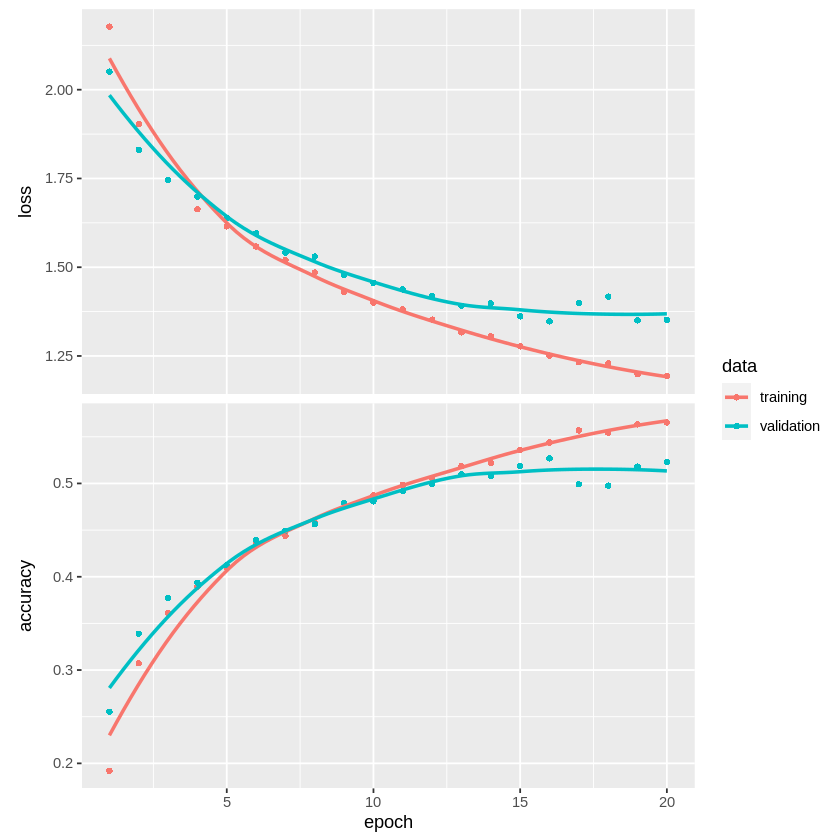

In [ ]:
# train the model
history <- model %>% fit(
  X_train, Y_train, 
  epochs = 20, batch_size=batch_size,
  verbose=1, validation_data = list(X_val, Y_val))
plot(history)

In [26]:
results <- model %>% evaluate(X_test, Y_test, verbose=0)
results

loss accuracy 
1.050382 0.634600

1 input_1 
2 block1_conv1 
3 block1_conv2 
4 block1_pool 
5 block2_conv1 
6 block2_conv2 
7 block2_pool 
8 block3_conv1 
9 block3_conv2 
10 block3_conv3 
11 block3_pool 
12 block4_conv1 
13 block4_conv2 
14 block4_conv3 
15 block4_pool 
16 block5_conv1 
17 block5_conv2 
18 block5_conv3 
19 block5_pool 


`geom_smooth()` using formula 'y ~ x'



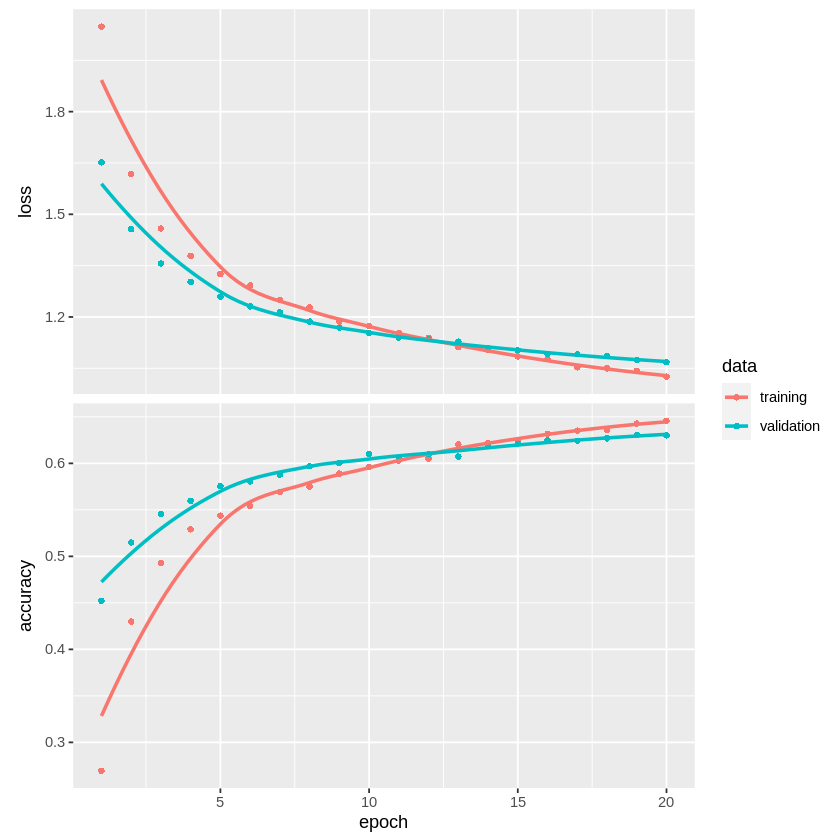

In [25]:
# once more
layers <- base_model$layers
for (i in 1:length(layers))
  cat(i, layers[[i]]$name, "\n")

freeze_weights(base_model, from = 1, to = 15)
unfreeze_weights(base_model, from = 15)

model %>% compile(
  optimizer = optimizer_sgd(lr = 0.0001, momentum = 0.9), 
  loss = 'categorical_crossentropy',
  metrics = c("accuracy")
)

history <- model %>% fit(
  X_train, Y_train, 
  epochs = 20,
  batch_size=128,
  verbose=1,
  validation_data = list(X_val, Y_val))

plot(history)

In [ ]:
results <- model %>% evaluate(X_test, Y_test, verbose=0)
results

loss accuracy 
1.332254 0.524200

# Additional Task

xxx

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  
*...*

In [ ]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] reshape2_1.4.4   kableExtra_1.2.1 ggplot2_3.3.2    RCurl_1.98-1.2  
[5] tensorflow_2.2.0 keras_2.3.0.0   

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3       reticulate_1.16    tidyselect_1.1.0   xfun_0.16         
 [5] repr_1.1.0         purrr_0.3.4